# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import scipy.stats as stats
import numpy as np


In [2]:

import plotly.express as px
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
# Importing the saved CSV file into dataframe 
# Imported this dataframe that was created in our EDA notebook
flights_df = pd.read_csv("/Users/ckz/Desktop/DATA_SCIENCE_BOOTCAMP/Midterm-project/flights_df.csv")

# print the first few rows of the DataFrame
flights_df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,first_dep_time,total_add_gtime,longest_add_gtime,no_name,month,dep_hour,arr_hour,taxi_time,origin_state,flight_distance_category
0,2018-01-01,B6,B6,B6,880,B6,N794JB,880,12954,LGB,...,NaN,NaN,NaN,NaN,1,7,8,83.0,CA,SHORT
1,2018-01-01,B6,B6,B6,885,B6,N337JB,885,12478,JFK,...,NaN,NaN,NaN,NaN,1,7,9,120.0,NY,SHORT
2,2018-01-01,B6,B6,B6,886,B6,N337JB,886,14492,RDU,...,NaN,NaN,NaN,NaN,1,10,11,102.0,NC,SHORT
3,2018-01-01,B6,B6,B6,889,B6,N318JB,889,11278,DCA,...,NaN,NaN,NaN,NaN,1,18,19,162.0,DC,SHORT
4,2018-01-01,B6,B6,B6,891,B6,N348JB,891,10721,BOS,...,NaN,NaN,NaN,NaN,1,6,9,317.0,MA,MEDIUM


In [4]:
# # Shuffle the data in the DataFrame and create a sample with half the size
sample_size = len(flights_df) // 10

flights_df = flights_df.sample(n=sample_size, random_state=42)

## Reset the index of the shuffled sample

flights_df.reset_index(drop=True, inplace=True)

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [5]:
flights_df['avg_monthly_arr_delay'] = flights_df.groupby('month')['arr_delay'].transform('mean')

In [6]:
flights_df.isnull().sum()

fl_date                          0
mkt_unique_carrier               0
branded_code_share               0
mkt_carrier                      0
mkt_carrier_fl_num               0
op_unique_carrier                0
tail_num                         0
op_carrier_fl_num                0
origin_airport_id                0
origin                           0
origin_city_name                 0
dest_airport_id                  0
dest                             0
dest_city_name                   0
crs_dep_time                     0
dep_time                         0
dep_delay                        0
taxi_out                         0
wheels_off                       0
wheels_on                        0
taxi_in                          0
crs_arr_time                     0
arr_time                         0
arr_delay                        0
cancelled                        0
cancellation_code           155904
diverted                         0
dup                              0
crs_elapsed_time    

In [7]:
# This feature creates the avg taxi times for the arrival hour 
flights_df['avg_taxi_times_arr'] = flights_df.groupby('arr_hour')['taxi_time'].transform('mean')

In [8]:
flights_df.shape

(155904, 50)

In [9]:
flights_df['fl_date'].dtype

dtype('O')

In [11]:
# Group the flights data by origin airport and count the number of flights for each airport
airport_counts = flights_df.groupby('origin')['flights'].transform('count')

# Determine the thresholds for each category based on the quartiles
thresholds = [0, airport_counts.quantile(0.25), airport_counts.quantile(0.5), airport_counts.quantile(0.75), np.inf]

# Define the categories
categories = ['Not Busy', 'Moderate', 'Busy', 'Very Busy']

# Assign the traffic category based on the number of flights from each airport
flights_df['traffic'] = pd.cut(airport_counts, bins=thresholds, labels=categories, right=False)

In [12]:
flights_df['traffic'].isnull().sum()

0

In [13]:
flights_df.tail(20)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,no_name,month,dep_hour,arr_hour,taxi_time,origin_state,flight_distance_category,avg_monthly_arr_delay,avg_taxi_times_arr,traffic
155884,2019-04-26,WN,WN,WN,2272,WN,N733SA,2272,14107,PHX,...,NaN,4,7,8,88.0,AZ,SHORT,4.366929,126.234424,Busy
155885,2018-10-01,DL,DL,DL,2034,DL,N307DX,2034,14492,RDU,...,NaN,10,16,17,95.0,NC,SHORT,2.935771,175.377978,Moderate
155886,2018-11-09,UA,UA_CODESHARE,UA,6039,YV,N86309,6039,14100,PHL,...,NaN,11,16,19,225.0,PA,MEDIUM,2.327676,174.828259,Busy
155887,2019-08-19,WN,WN,WN,44,WN,N793SA,44,13198,MCI,...,NaN,8,14,16,132.0,MO,MEDIUM,9.417241,191.172606,Moderate
155888,2019-04-26,HA,HA,HA,280,HA,N477HA,280,13830,OGG,...,NaN,4,14,14,21.0,HI,SHORT,4.366929,179.011751,Not Busy
155889,2019-03-09,WN,WN,WN,4994,WN,N7742B,4994,10800,BUR,...,NaN,3,9,10,91.0,CA,SHORT,3.549422,154.666393,Not Busy
155890,2019-05-14,HA,HA,HA,546,HA,N491HA,546,12173,HNL,...,NaN,5,19,20,61.0,HI,SHORT,6.318598,169.635732,Moderate
155891,2019-01-17,WN,WN,WN,695,WN,N7849A,695,10397,ATL,...,NaN,1,21,23,123.0,GA,MEDIUM,3.679964,-121.539468,Very Busy
155892,2019-06-18,AA,AA_CODESHARE,AA,4078,MQ,N846AE,4078,11298,DFW,...,NaN,6,8,10,87.0,TX,SHORT,10.367926,154.666393,Very Busy
155893,2018-10-21,NK,NK,NK,1455,NK,N632NK,1455,10529,BDL,...,NaN,10,11,14,267.0,CT,MEDIUM,2.935771,179.011751,Not Busy


In [14]:
states = {
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AS': 'O',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'GU': 'O',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MP': 'O',
        'MS': 'S',
        'MT': 'W',
        'NA': 'O',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'PR': 'O',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VI': 'O',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}

region_mapping = {
    'O': 'Other',
    'S': 'South',
    'W': 'West',
    'N': 'North',
    'M': 'Midwest'
}

# Clean the 'state_code' values by converting to strings and removing leading/trailing whitespaces
flights_df['orgin_state'] = flights_df['origin_state'].astype(str).str.strip()

# Create a new column 'Region' based on the mapping
flights_df['Region'] = flights_df['origin_state'].map(states).map(region_mapping)

In [15]:
from pandas.tseries.holiday import USFederalHolidayCalendar as holiday_calendar

In [16]:
from datetime import datetime

In [17]:
flights_df['fl_date'] = flights_df['fl_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [18]:
# holiday_cal
cal = holiday_calendar()
dr = flights_df['fl_date'] 
holidays = cal.holidays(start=dr.min(), end=dr.max())
flights_df['holiday'] = flights_df['fl_date'].dt.date.astype('datetime64').isin(holidays).astype(int)
flights_df.tail(5)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,arr_hour,taxi_time,origin_state,flight_distance_category,avg_monthly_arr_delay,avg_taxi_times_arr,traffic,orgin_state,Region,holiday
155899,2019-12-17,DL,DL_CODESHARE,DL,5763,CP,N603CZ,5763,12892,LAX,...,19,196.0,CA,SHORT,5.246998,174.828259,Very Busy,CA,West,0
155900,2018-12-10,DL,DL,DL,1148,DL,N332NW,1148,10397,ATL,...,8,95.0,GA,SHORT,5.246998,126.234424,Very Busy,GA,South,0
155901,2019-10-06,AA,AA,AA,1408,AA,N973NN,1408,14747,SEA,...,5,-1840.0,WA,LONG,2.935771,-984.269841,Very Busy,WA,West,0
155902,2019-11-11,UA,UA,UA,225,UA,N79011,225,11618,EWR,...,10,214.0,NJ,MEDIUM,2.327676,154.666393,Busy,NJ,North,1
155903,2019-11-02,DL,DL,DL,1145,DL,N333NW,1145,11433,DTW,...,17,117.0,MI,MEDIUM,2.327676,175.377978,Busy,MI,West,0


In [19]:
flights_df.head(5)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,arr_hour,taxi_time,origin_state,flight_distance_category,avg_monthly_arr_delay,avg_taxi_times_arr,traffic,orgin_state,Region,holiday
0,2019-06-04,AA,AA_CODESHARE,AA,6051,CP,N213NN,6051,14747,SEA,...,18,206.0,WA,MEDIUM,10.367926,169.508046,Very Busy,WA,West,0
1,2018-06-22,DL,DL,DL,2773,DL,N939AT,2773,11433,DTW,...,12,-14.0,MI,SHORT,10.367926,160.199192,Busy,MI,West,0
2,2018-06-29,UA,UA_CODESHARE,UA,6280,YV,N85320,6280,14100,PHL,...,15,198.0,PA,MEDIUM,10.367926,188.382076,Busy,PA,North,0
3,2019-07-12,DL,DL_CODESHARE,DL,6223,G7,N367CA,6223,11066,CMH,...,16,36.0,OH,SHORT,8.770702,191.172606,Not Busy,OH,Midwest,0
4,2018-08-13,DL,DL_CODESHARE,DL,4717,OO,N241SY,4717,15376,TUS,...,13,111.0,AZ,SHORT,9.417241,170.208429,Not Busy,AZ,West,0


In [20]:
flight_df = flights_df[['fl_date','mkt_unique_carrier','avg_taxi_times_arr','avg_monthly_arr_delay','flight_distance_category','taxi_time','arr_hour','month','distance','air_time','traffic','Region','holiday','arr_delay']]



In [21]:
flight_df.head(20)

,fl_date,mkt_unique_carrier,avg_taxi_times_arr,avg_monthly_arr_delay,flight_distance_category,taxi_time,arr_hour,month,distance,air_time,traffic,Region,holiday,arr_delay
0,2019-06-04,AA,169.508046,10.367926,MEDIUM,206.0,18,6,954.0,126.0,Very Busy,West,0,-10.0
1,2018-06-22,DL,160.199192,10.367926,SHORT,-14.0,12,6,235.0,46.0,Busy,West,0,-15.0
2,2018-06-29,UA,188.382076,10.367926,MEDIUM,198.0,15,6,1325.0,178.0,Busy,North,0,-16.0
3,2019-07-12,DL,191.172606,8.770702,SHORT,36.0,16,7,155.0,36.0,Not Busy,Midwest,0,9.0
4,2018-08-13,DL,170.208429,9.417241,SHORT,111.0,13,8,451.0,71.0,Not Busy,West,0,-9.0
5,2019-04-03,DL,175.377978,4.366929,SHORT,79.0,17,4,229.0,39.0,Busy,West,0,0.0
6,2019-10-26,WN,179.011751,2.935771,SHORT,10.0,14,10,484.0,70.0,Very Busy,South,0,63.0
7,2019-08-16,WN,-243.584248,9.417241,SHORT,92.0,6,8,337.0,52.0,Very Busy,West,0,0.0
8,2019-03-08,DL,160.662124,3.549422,MEDIUM,123.0,11,3,646.0,83.0,Very Busy,South,0,-10.0
9,2018-12-11,DL,154.666393,5.246998,MEDIUM,208.0,10,12,957.0,128.0,Busy,South,0,-13.0


In [22]:
flights_df.describe()

,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,...,total_add_gtime,longest_add_gtime,no_name,month,dep_hour,arr_hour,taxi_time,avg_monthly_arr_delay,avg_taxi_times_arr,holiday
count,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,...,1005.000000,1005.000000,0.0,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000,155904.000000
mean,2715.555650,2715.487781,12683.964542,12677.623557,1330.124051,1335.936564,10.517716,25.062571,1360.999134,1460.536253,...,37.380100,37.177114,NaN,6.603654,13.029794,14.557830,99.537119,5.472451,99.537119,0.025798
std,1851.834196,1851.859519,1522.746455,1523.454689,489.447777,503.313591,47.829335,112.795921,504.652774,532.849226,...,31.630474,31.133955,NaN,3.405872,4.878387,5.165701,412.571766,2.835186,250.462167,0.158533
min,1.000000,1.000000,10135.000000,10135.000000,1.000000,1.000000,-72.000000,-2386.000000,1.000000,1.000000,...,1.000000,1.000000,NaN,1.000000,0.000000,0.000000,-2363.000000,1.357284,-1839.722864,0.000000
25%,1121.000000,1121.000000,11292.000000,11292.000000,915.000000,919.000000,-6.000000,12.000000,935.000000,1044.000000,...,16.000000,16.000000,NaN,4.000000,9.000000,11.000000,85.000000,2.935771,146.529532,0.000000
50%,2304.000000,2304.000000,12889.000000,12889.000000,1325.000000,1330.000000,-2.000000,18.000000,1344.000000,1502.000000,...,28.000000,28.000000,NaN,7.000000,13.000000,15.000000,120.000000,5.246998,160.662124,0.000000
75%,4262.000000,4262.000000,14057.000000,14057.000000,1735.000000,1744.000000,6.000000,53.000000,1759.000000,1908.000000,...,47.000000,46.000000,NaN,10.000000,17.000000,19.000000,213.000000,8.770702,174.828259,0.000000
max,9389.000000,9389.000000,16869.000000,16869.000000,2359.000000,2400.000000,1619.000000,287.000000,2400.000000,2400.000000,...,215.000000,215.000000,NaN,12.000000,23.000000,23.000000,2338.000000,10.367926,191.172606,1.000000


In [23]:
df_encoded = pd.get_dummies(data=flights_df, columns=['mkt_unique_carrier'], drop_first=False)
df_encoded = pd.get_dummies(data=df_encoded, columns=['flight_distance_category'], drop_first=False)
df_encoded = pd.get_dummies(data=df_encoded, columns=['month'], drop_first=False)
df_encoded = pd.get_dummies(data=df_encoded, columns=['Region'], drop_first=False)
df_encoded = pd.get_dummies(data=df_encoded, columns=['traffic'], drop_first=False)

In [24]:
# Separate numeric columns and encoded columns
numeric_columns = ['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'taxi_time', 'arr_hour', 'distance', 'air_time','arr_delay']
encoded_columns = df_encoded.drop(columns=numeric_columns)

# Scale the numeric columns
scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(df_encoded[numeric_columns])

# Create a DataFrame for the scaled numeric data
df_scaled_numeric = pd.DataFrame(scaled_numeric_data, columns=numeric_columns)

# Rejoin the scaled numeric data with the encoded columns
df_scaled_encoded = pd.concat([df_scaled_numeric, encoded_columns], axis=1)

In [25]:
df_scaled_encoded.head()

,avg_taxi_times_arr,avg_monthly_arr_delay,taxi_time,arr_hour,distance,air_time,arr_delay,fl_date,branded_code_share,mkt_carrier,...,month_12,Region_Midwest,Region_North,Region_Other,Region_South,Region_West,traffic_Not Busy,traffic_Moderate,traffic_Busy,traffic_Very Busy
0,0.279368,1.726691,0.258048,0.666353,0.313522,0.260965,-0.309121,2019-06-04,AA_CODESHARE,AA,...,0,0,0,0,0,1,0,0,0,1
1,0.242201,1.726691,-0.275195,-0.495158,-0.914417,-0.890950,-0.409015,2018-06-22,DL,DL,...,0,0,0,0,0,1,0,0,1,0
2,0.354725,1.726691,0.238657,0.085597,0.947132,1.009709,-0.428994,2018-06-29,UA_CODESHARE,UA,...,0,0,1,0,0,0,0,0,1,0
3,0.365867,1.163331,-0.154003,0.279183,-1.051045,-1.034939,0.070476,2019-07-12,DL_CODESHARE,DL,...,0,1,0,0,0,0,1,0,0,0
4,0.282165,1.391373,0.027784,-0.301573,-0.545523,-0.530976,-0.289142,2018-08-13,DL_CODESHARE,DL,...,0,0,0,0,0,1,1,0,0,0


In [26]:
df_scaled_encoded.columns

Index(['avg_taxi_times_arr', 'avg_monthly_arr_delay', 'taxi_time', 'arr_hour',
       'distance', 'air_time', 'arr_delay', 'fl_date', 'branded_code_share',
       'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'cancelled', 'cancellation_code',
       'diverted', 'dup', 'crs_elapsed_time', 'actual_elapsed_time', 'flights',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name', 'dep_hour', 'origin_state',
       'orgin_state', 'holiday', 'mkt_unique_carrier_AA',
       'mkt_unique_carrier_AS', 'mkt_unique_carrier_B6',
       'mkt_unique_carrier_DL', 'mkt_unique_carrier_F9',
       'mkt

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [27]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [28]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [29]:
#To convert the continuous variable 'arr_delay' into a classification problem and create discrete classes

# Define the class thresholds/ranges
thresholds = [-float("inf"), 0, 15, 30, float("inf")]

df_scaled_encoded['delay_class'] = pd.cut(df_scaled_encoded['arr_delay'], bins=[-float("inf"), 0, 15, 30, float("inf")], labels=[0, 1, 2, 3])


# Print the DataFrame
df_scaled_encoded.head()


,avg_taxi_times_arr,avg_monthly_arr_delay,taxi_time,arr_hour,distance,air_time,arr_delay,fl_date,branded_code_share,mkt_carrier,...,Region_Midwest,Region_North,Region_Other,Region_South,Region_West,traffic_Not Busy,traffic_Moderate,traffic_Busy,traffic_Very Busy,delay_class
0,0.279368,1.726691,0.258048,0.666353,0.313522,0.260965,-0.309121,2019-06-04,AA_CODESHARE,AA,...,0,0,0,0,1,0,0,0,1,0
1,0.242201,1.726691,-0.275195,-0.495158,-0.914417,-0.890950,-0.409015,2018-06-22,DL,DL,...,0,0,0,0,1,0,0,1,0,0
2,0.354725,1.726691,0.238657,0.085597,0.947132,1.009709,-0.428994,2018-06-29,UA_CODESHARE,UA,...,0,1,0,0,0,0,0,1,0,0
3,0.365867,1.163331,-0.154003,0.279183,-1.051045,-1.034939,0.070476,2019-07-12,DL_CODESHARE,DL,...,1,0,0,0,0,1,0,0,0,1
4,0.282165,1.391373,0.027784,-0.301573,-0.545523,-0.530976,-0.289142,2018-08-13,DL_CODESHARE,DL,...,0,0,0,0,1,1,0,0,0,0


In [30]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [31]:
#Separate the input features (X) and the new target variable (y):

X = df_scaled_encoded[['flight_distance_category_LONG',
                      'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT', 'arr_hour',
                      'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
                      'month_9', 'month_10', 'month_11', 'month_12', 'distance', 'air_time',
                      'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_scaled_encoded['delay_class']

#Split the data into training and testing sets:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Create models using SMV and Naive Bayes



# Train the Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions using the Naive Bayes model
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.594208011288926


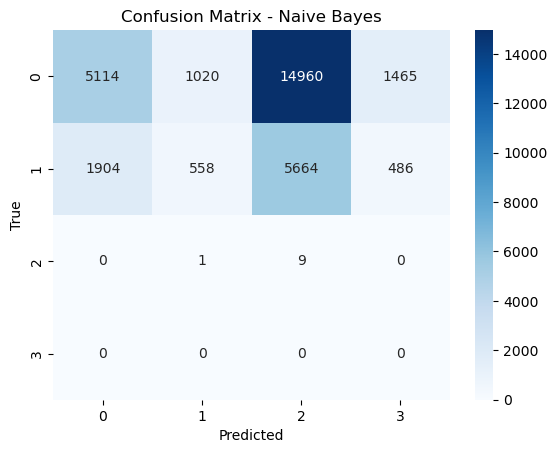

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, nb_predictions)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

In [32]:
# Added more features (mkt unique carrier) to improve model


#Separate the input features (X) and the new target variable (y):

X = df_scaled_encoded[['flight_distance_category_LONG',
                      'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT', 'arr_hour',
                      'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
                      'month_9', 'month_10', 'month_11', 'month_12', 'distance', 'air_time','mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',                    'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
                       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4','mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',              'mkt_unique_carrier_UA', 'mkt_unique_carrier_VX',
                       'mkt_unique_carrier_WN',
                      'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_scaled_encoded['delay_class']

#Split the data into training and testing sets:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Create models using Naive Bayes



# Train the Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions using the Naive Bayes model
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.18219428498123857


In [33]:
#Separate the input features (X) and the new target variable (y):

X = df_scaled_encoded[['flight_distance_category_LONG',
                      'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT', 'arr_hour',
                      'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
                      'month_9', 'month_10', 'month_11', 'month_12', 'distance', 'air_time',
                      'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_scaled_encoded['delay_class']

#Split the data into training and testing sets:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Make predictions using the SVM model
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.7237420223854271


In [37]:
df_scaled_encoded['delay_class'].unique()

[0, 1, 2, 3]
Categories (4, int64): [0 < 1 < 2 < 3]

In [38]:
class_counts = df_scaled_encoded['delay_class'].value_counts()
print(class_counts)

0    113130
1     42679
2        92
3         3
Name: delay_class, dtype: int64


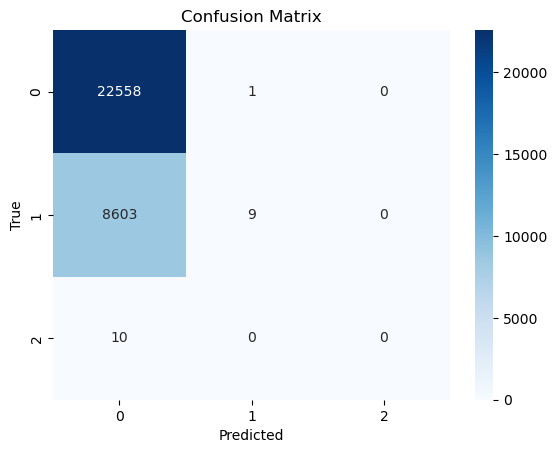

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, svm_predictions)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [42]:
## Blended ensemble using 3 models

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assume X contains your feature data and y contains the target variable

X = df_scaled_encoded[['flight_distance_category_LONG',
                      'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT', 'arr_hour',
                      'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
                      'month_9', 'month_10', 'month_11', 'month_12', 'distance', 'air_time',
                      'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_scaled_encoded['delay_class']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the individual classifiers or base models
model1 = RandomForestClassifier()
model2 = LogisticRegression()
model3 = GaussianNB()

# Create the voting ensemble model with the individual models
voting_model = VotingClassifier(
    estimators=[('rf', model1), ('lr', model2), ('nb', model3)],
    voting='hard'  # Use majority voting
)

# Fit the voting model to the training data
voting_model.fit(X_train, y_train)

# Predict on the test data
y_pred = voting_model.predict(X_test)

# Evaluate the accuracy of the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/Users/ckz/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.722844039639524


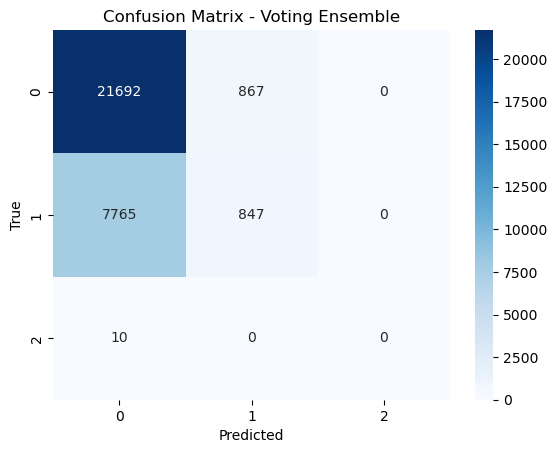

In [43]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Voting Ensemble')
plt.show()

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X contains your feature data and y contains the target variable

X = df_scaled_encoded[['flight_distance_category_LONG',
                      'flight_distance_category_MEDIUM', 'flight_distance_category_SHORT', 'arr_hour',
                      'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
                      'month_9', 'month_10', 'month_11', 'month_12', 'distance', 'air_time','mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',                    'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
                       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4','mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',              'mkt_unique_carrier_UA', 'mkt_unique_carrier_VX',
                       'mkt_unique_carrier_WN',
                      'traffic_Not Busy', 'traffic_Moderate', 'traffic_Busy', 'traffic_Very Busy', 'holiday']]
y = df_scaled_encoded['delay_class']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the individual classifiers or base models
model1 = RandomForestClassifier()
model2 = LogisticRegression()
model3 = GaussianNB()

# Create the voting ensemble model with the individual models
voting_model = VotingClassifier(
    estimators=[('rf', model1), ('lr', model2), ('nb', model3)],
    voting='hard'  # Use majority voting
)

# Fit the voting model to the training data
voting_model.fit(X_train, y_train)

# Predict on the test data
y_pred = voting_model.predict(X_test)

# Evaluate the accuracy of the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/Users/ckz/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.728103652865527


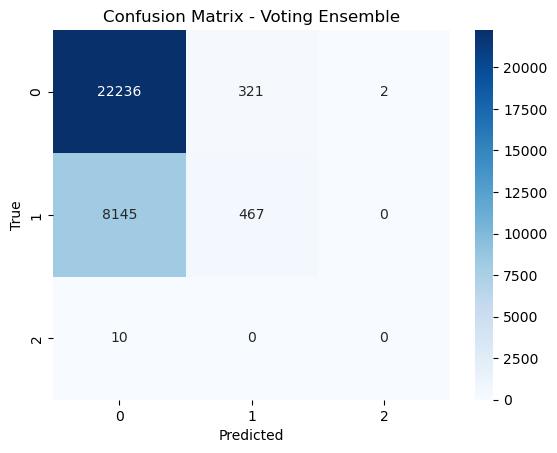

In [45]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Voting Ensemble')
plt.show()

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**